# import libraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats import iqr
from functools import partial, reduce
from sqlalchemy import create_engine
import datetime
import warnings
import patsy
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import zip_longest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
import seaborn as sb

# Read the data

In [25]:
df= pd.read_excel (r'regmor.xlsx')

In [26]:
df

,Price,Districts,Link,Area,Front,Bedrooms,Salon,Bathrooms,Street_width,Age
0,"1,650,000 ريال",AlArid,https://sa.aqar.fm/فلل-للبيع/city/north-city/ح...,200 م²,north,7,1,5,20 م,5 سنة
1,"1,150,000 ريال",city,https://sa.aqar.fm/فلل-للبيع/city/east-city/حي...,256 م²,south,7,1,1,5,20 م
2,"1,270,000 ريال",AlRemal,https://sa.aqar.fm/فلل-للبيع/city/east-city/حي...,285 م²,west,4,1,2,5,20 م
3,"1,250,000 ريال",AlKaleej,https://sa.aqar.fm/فلل-للبيع/city/east-city/حي...,560 م²,north,5,3,1,3,18 م
4,"1,300,000 ريال",NaN,https://sa.aqar.fm/فلل-للبيع/city/east-city/حي...,235 م²,south,5,2,5,15 م,NaN
...,...,...,...,...,...,...,...,...,...,...
2079,"1,200,000 ريال",street,https://sa.aqar.fm/فلل-للبيع/city/east-city/حي...,625 م²,north-west,4,2,2,2,10 م
2080,"1,270,000 ريال",AlRemal,https://sa.aqar.fm/فلل-للبيع/city/east-city/حي...,285 م²,west,4,1,2,5,20 م
2081,"900,000 ريال",AlDarAlbaida,https://sa.aqar.fm/فلل-للبيع/city/south-city/ح...,230 م²,south-west,7,3,5,20 م,NaN
2082,"650,000 ريال",NaN,https://sa.aqar.fm/فلل-للبيع/city/south-city/ح...,390 م²,south,5,1,1,5,18 م


# Data Cleaning

In [27]:
df['Street_width'] = df['Street_width'].str.replace('م', '')
df['Street_width'] = df['Street_width'].str.replace('سنة', '')
df['Age'] = df['Age'].str.replace('م', '')
df['Age'] = df['Age'].str.replace('سنة', '')
df['Area'] = df['Area'].str.replace('م²', '')
df['Price'] = df['Price'].str.replace('ريال', '')
df["Price"]=df.Price.str.replace(',', '')

In [28]:
df["Price"] = df.Price.astype(float)
df["Age"] = df.Age.astype(float)
df["Area"] = df.Area.astype(float)
df["Street_width"] = df.Street_width.astype(float)
df.drop(['Link'],axis=1 , inplace = True)
df.drop(['Bathrooms'],axis=1 , inplace = True)

In [29]:
df["Age"].fillna(0, inplace = True)


In [30]:
df.dropna(subset=[ 'Districts'], inplace=True)
df['Districts']=df['Districts'].str.strip()
df.drop(df[df['Districts'] == 'street' ].index, inplace = True)
df.drop(df[df['Districts'] == 'city' ].index, inplace = True)

In [31]:
df

,Price,Districts,Area,Front,Bedrooms,Salon,Street_width,Age
0,1650000.0,AlArid,200.0,north,7,1,20.0,5.0
2,1270000.0,AlRemal,285.0,west,4,1,5.0,20.0
3,1250000.0,AlKaleej,560.0,north,5,3,3.0,18.0
6,8000000.0,Al-Hamra,1185.0,west,7,1,5.0,25.0
10,2000000.0,AlRemal,378.0,north,7,2,5.0,15.0
...,...,...,...,...,...,...,...,...
2077,1350000.0,Al-Naseem,312.0,east,7,3,5.0,10.0
2078,1300000.0,Al-Muraba,498.0,south-east,6,5,10.0,35.0
2080,1270000.0,AlRemal,285.0,west,4,1,5.0,20.0
2081,900000.0,AlDarAlbaida,230.0,south-west,7,3,20.0,0.0


# Converting categorical values

In [8]:
df = pd.get_dummies(df, drop_first=True) 
df.head(3)

,Price,Area,Bedrooms,Salon,Street_width,Age,Districts_Al-Aqiq,Districts_Al-Aziziyah,Districts_Al-Ghadeer,Districts_Al-Hamra,...,Districts_tuwaiq,Front_4-streets,Front_east,Front_north,Front_north-east,Front_north-west,Front_south,Front_south-east,Front_south-west,Front_west
0,1650000.0,200.0,7,1,20.0,5.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1270000.0,285.0,4,1,5.0,20.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1250000.0,560.0,5,3,3.0,18.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Split the data into : Train set and Test set

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
df = train_set.copy()

# Fill null values

In [11]:
ms=df.Street_width.mean()

In [12]:
df["Street_width"].fillna(ms, inplace = True)


In [14]:
test_set["Street_width"].fillna(ms, inplace = True)

---------------------------

# Correlation after converting categorical values

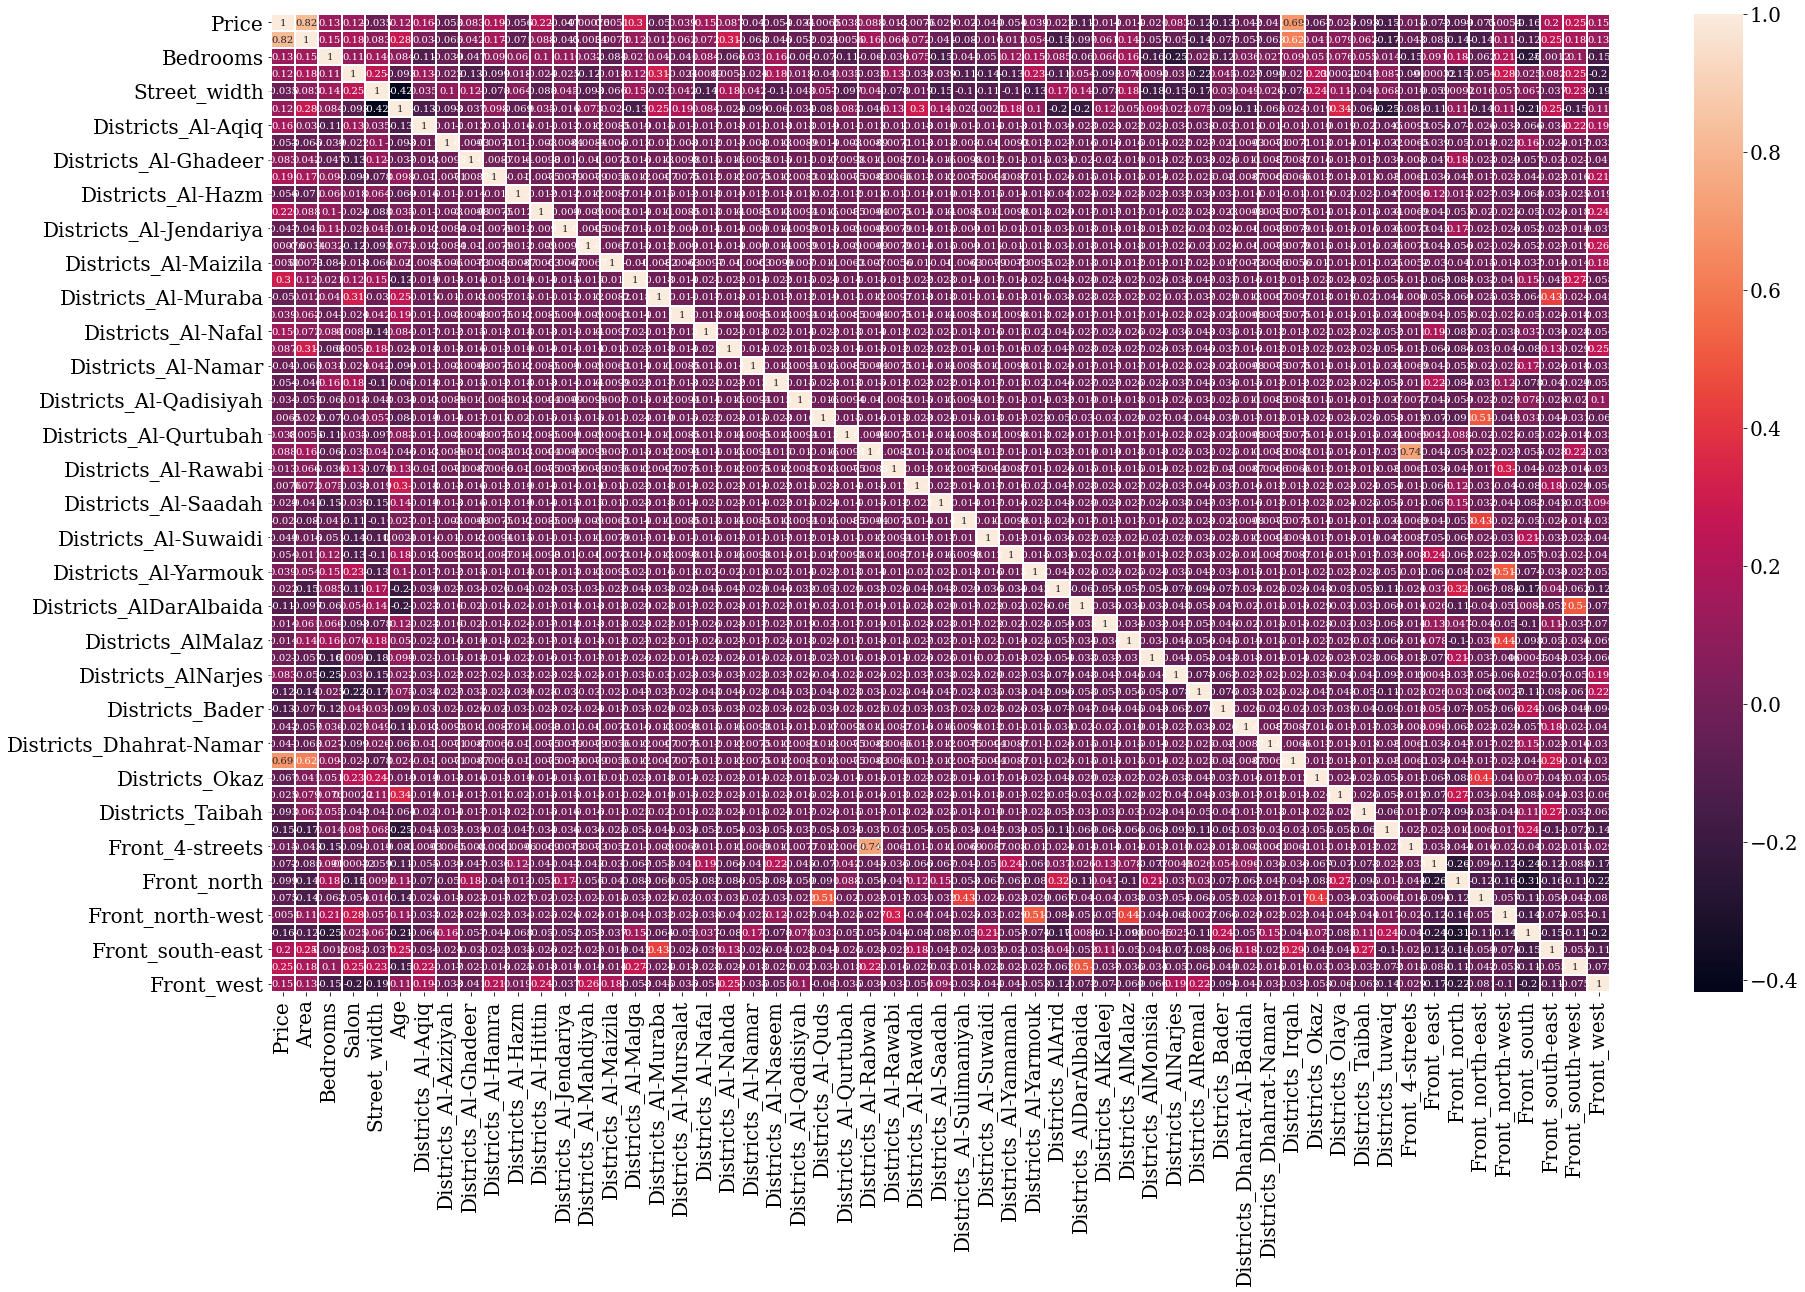

In [15]:
correlation = df.corr()
plt.figure(figsize=(30,18))
plt.rc('xtick', labelsize=20,color ="#000000") 
plt.rc('ytick', labelsize=20,color ="#000000")
plt.rcParams["font.family"] = "serif"
sns.heatmap(correlation, annot = True, linewidth = 1);

# Cross Validaiton

In [16]:

X, y = df.drop('Price',axis=1), df['Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)
X, y = np.array(X), np.array(y)
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s,poly_cv = [], [] ,[]

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)
    poly = LinearRegression()
    

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
   
    
    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    lm.fit(X_train_poly, y_train)
    poly_cv.append(lm.score(X_val_poly, y_val))
    
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
    

print('Linear regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')
print('poly scores: ', poly_cv, '\n')

print(f'Linear mean cv r^2: {np.mean(cv_lm_r2s):.6f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.6f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'poly mean cv r^2: {np.mean(poly_cv):.6f} +- {np.std(poly_cv):.3f}')

Linear regression scores:  [0.959469315997559, 0.9222005634565557, 0.9757105728921993, 0.9742956192509574, 0.9711915109342425]
Ridge scores:  [0.9594607984489156, 0.9228296391837595, 0.9755100324668946, 0.974198263960787, 0.9713117985717219] 

poly scores:  [1.0, 1.0, 1.0, 1.0, 1.0] 

Linear mean cv r^2: 0.960574 +- 0.020
Ridge mean cv r^2: 0.960662 +- 0.020
poly mean cv r^2: 1.000000 +- 0.000


# Testing

In [17]:
X_test, y_test = test_set.drop('Price',axis=1), test_set['Price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.965


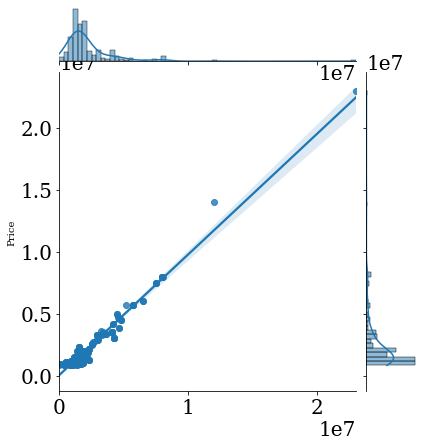

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
lm_reg = Ridge(alpha=1).fit(X_scaled,y)


y_predicted = lm_reg.predict(X_test_scaled)
#Plot Our Actual and Predicted Values
sns.jointplot(x=y_predicted,y=y_test,kind='reg')

In [22]:
from sklearn import metrics

def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

results_df = pd.DataFrame(data=[[ *evaluate(y_test, y_predicted)]],columns=[ 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df


,MAE,MSE,RMSE,R2 Square
0,252274.598312,1.531531e+11,391347.79079,0.965486


In [23]:
print(lm_reg.intercept_)
print(lm_reg.coef_)

2318863.293071161
[ 1.56738417e+06  1.96448137e+05  1.58586664e+05 -6.81548269e+04
  9.16305505e+04  2.46513135e+05 -2.10647726e+04  1.49214383e+05
  1.62791073e+05 -7.34318833e+04  3.33662067e+05 -7.91946905e+04
 -2.11319725e+04 -3.10859593e+03  4.11649812e+05 -3.57082416e+05
 -5.46426716e+04  1.57273255e+05 -3.17226802e+05 -8.66757978e+03
 -1.77520300e+05 -1.51412564e+04 -1.44799054e+05  5.59225055e+04
 -3.32381599e+05 -1.23184821e+05 -2.52244617e+05 -3.14851320e+04
 -6.63690708e+04 -9.42077102e+04 -2.23431820e+05 -1.06202283e+05
  7.93942885e+04 -2.90913397e+05 -2.39385605e+05 -3.27436940e+05
  6.72374094e+03  2.33590873e+05 -1.18224170e+05 -2.29686358e+05
 -8.94489692e+04 -8.12037944e+02  5.88418738e+05 -4.12156246e+05
 -2.55754639e+05 -4.25065647e+05 -1.81394177e+05  2.88158624e+05
 -1.13379759e+04 -1.20745753e+05  2.47790495e+05 -7.13179727e+04
 -1.22909329e+05  1.66157961e+05  2.44439896e+05 -9.09951723e+04]
